In [1]:
import os
import tensorflow.keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = tensorflow.keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tensorflow.keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = tensorflow.keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = tensorflow.keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = tensorflow.keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    tensorflow.keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [======

50000/50000 [==============================] - 2s 30us/sample - loss: 1.6151 - accuracy: 0.5240 - val_loss: 1.6794 - val_accuracy: 0.4922
Epoch 49/50
50000/50000 [==============================] - 1s 30us/sample - loss: 1.6132 - accuracy: 0.5237 - val_loss: 1.7108 - val_accuracy: 0.4862
Epoch 50/50
50000/50000 [==============================] - 1s 30us/sample - loss: 1.6116 - accuracy: 0.5250 - val_loss: 1.6605 - val_accuracy: 0.5101
Experiment with Regulizer = 0.000100
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________________________

50000/50000 [==============================] - 2s 30us/sample - loss: 1.0869 - accuracy: 0.6692 - val_loss: 1.5293 - val_accuracy: 0.5249
Epoch 46/50
50000/50000 [==============================] - 2s 30us/sample - loss: 1.0761 - accuracy: 0.6719 - val_loss: 1.5725 - val_accuracy: 0.5124
Epoch 47/50
50000/50000 [==============================] - 2s 30us/sample - loss: 1.0648 - accuracy: 0.6765 - val_loss: 1.5154 - val_accuracy: 0.5315
Epoch 48/50
50000/50000 [==============================] - 2s 32us/sample - loss: 1.0560 - accuracy: 0.6788 - val_loss: 1.5668 - val_accuracy: 0.5223
Epoch 49/50
50000/50000 [==============================] - 2s 30us/sample - loss: 1.0397 - accuracy: 0.6831 - val_loss: 1.5603 - val_accuracy: 0.5204
Epoch 50/50
50000/50000 [==============================] - 2s 31us/sample - loss: 1.0261 - accuracy: 0.6898 - val_loss: 1.5766 - val_accuracy: 0.5227
Experiment with Regulizer = 0.000000
Model: "model"
____________________________________________________________

50000/50000 [==============================] - 2s 30us/sample - loss: 0.9721 - accuracy: 0.6580 - val_loss: 1.3848 - val_accuracy: 0.5185
Epoch 43/50
50000/50000 [==============================] - 1s 30us/sample - loss: 0.9569 - accuracy: 0.6643 - val_loss: 1.4115 - val_accuracy: 0.5107
Epoch 44/50
50000/50000 [==============================] - 1s 29us/sample - loss: 0.9473 - accuracy: 0.6676 - val_loss: 1.4019 - val_accuracy: 0.5204
Epoch 45/50
50000/50000 [==============================] - 1s 30us/sample - loss: 0.9352 - accuracy: 0.6686 - val_loss: 1.3548 - val_accuracy: 0.5348
Epoch 46/50
50000/50000 [==============================] - 1s 30us/sample - loss: 0.9230 - accuracy: 0.6735 - val_loss: 1.4019 - val_accuracy: 0.5217
Epoch 47/50
50000/50000 [==============================] - 1s 30us/sample - loss: 0.9073 - accuracy: 0.6803 - val_loss: 1.4629 - val_accuracy: 0.5134
Epoch 48/50
50000/50000 [==============================] - 2s 30us/sample - loss: 0.9024 - accuracy: 0.6829 - va

50000/50000 [==============================] - 2s 32us/sample - loss: 1.0074 - accuracy: 0.6454 - val_loss: 1.3833 - val_accuracy: 0.5257
Epoch 40/50
50000/50000 [==============================] - 2s 31us/sample - loss: 0.9928 - accuracy: 0.6529 - val_loss: 1.3333 - val_accuracy: 0.5401
Epoch 41/50
50000/50000 [==============================] - 2s 31us/sample - loss: 0.9767 - accuracy: 0.6566 - val_loss: 1.3855 - val_accuracy: 0.5319
Epoch 42/50
50000/50000 [==============================] - 1s 30us/sample - loss: 0.9696 - accuracy: 0.6601 - val_loss: 1.3739 - val_accuracy: 0.5279
Epoch 43/50
50000/50000 [==============================] - 2s 32us/sample - loss: 0.9577 - accuracy: 0.6629 - val_loss: 1.3483 - val_accuracy: 0.5332
Epoch 44/50
50000/50000 [==============================] - 2s 31us/sample - loss: 0.9472 - accuracy: 0.6695 - val_loss: 1.3604 - val_accuracy: 0.5394
Epoch 45/50
50000/50000 [==============================] - 2s 30us/sample - loss: 0.9331 - accuracy: 0.6729 - va

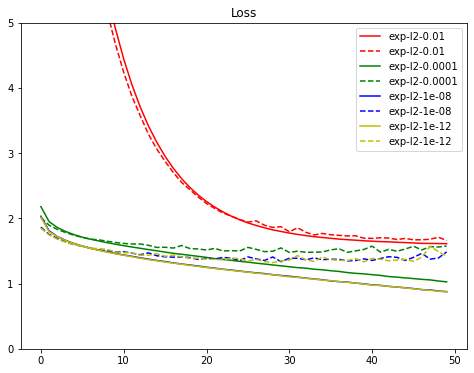

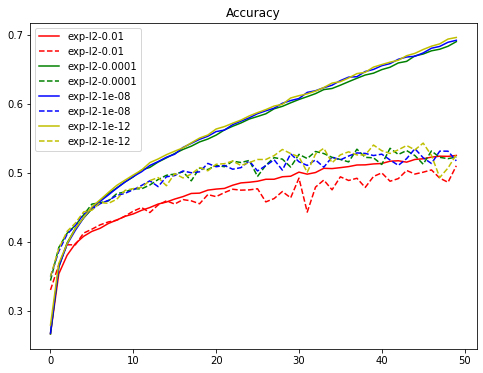

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [9]:
import itertools

In [11]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = tensorflow.keras.datasets.cifar10.load_data()

In [12]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from tensorflow.keras.regularizers import l1_l2

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = tensorflow.keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = tensorflow.keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = tensorflow.keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [17]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    tensorflow.keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000

50000/50000 [==============================] - 2s 43us/sample - loss: 198.7007 - accuracy: 0.2281 - val_loss: 41.1306 - val_accuracy: 0.2504
Epoch 2/10
50000/50000 [==============================] - 1s 29us/sample - loss: 19.1158 - accuracy: 0.1165 - val_loss: 7.3010 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 1s 29us/sample - loss: 4.1266 - accuracy: 0.1000 - val_loss: 2.6530 - val_accuracy: 0.1000
Epoch 4/10
50000/50000 [==============================] - 1s 29us/sample - loss: 2.4871 - accuracy: 0.0964 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 1s 29us/sample - loss: 2.4626 - accuracy: 0.0993 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 1s 29us/sample - loss: 2.4626 - accuracy: 0.0986 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [==============================] - 1s 29us/sample - loss: 2.4626 - accuracy: 0.0996 - val_

50000/50000 [==============================] - 2s 33us/sample - loss: 5.7006 - accuracy: 0.3920 - val_loss: 5.6404 - val_accuracy: 0.3995
Epoch 4/10
50000/50000 [==============================] - 2s 31us/sample - loss: 5.5707 - accuracy: 0.4153 - val_loss: 5.5092 - val_accuracy: 0.4242
Epoch 5/10
50000/50000 [==============================] - 2s 32us/sample - loss: 5.4558 - accuracy: 0.4318 - val_loss: 5.4118 - val_accuracy: 0.4321
Epoch 6/10
50000/50000 [==============================] - 2s 31us/sample - loss: 5.3521 - accuracy: 0.4446 - val_loss: 5.3150 - val_accuracy: 0.4436
Epoch 7/10
50000/50000 [==============================] - 1s 27us/sample - loss: 5.2519 - accuracy: 0.4554 - val_loss: 5.2314 - val_accuracy: 0.4449
Epoch 8/10
50000/50000 [==============================] - 1s 29us/sample - loss: 5.1584 - accuracy: 0.4647 - val_loss: 5.1248 - val_accuracy: 0.4577
Epoch 9/10
50000/50000 [==============================] - 1s 29us/sample - loss: 5.0669 - accuracy: 0.4717 - val_loss

Epoch 6/10
50000/50000 [==============================] - 1s 29us/sample - loss: 5.2406 - accuracy: 0.4438 - val_loss: 5.2046 - val_accuracy: 0.4449
Epoch 7/10
50000/50000 [==============================] - 1s 30us/sample - loss: 5.1459 - accuracy: 0.4556 - val_loss: 5.1167 - val_accuracy: 0.4555
Epoch 8/10
50000/50000 [==============================] - 1s 30us/sample - loss: 5.0562 - accuracy: 0.4653 - val_loss: 5.0389 - val_accuracy: 0.4554
Epoch 9/10
50000/50000 [==============================] - 1s 30us/sample - loss: 4.9690 - accuracy: 0.4753 - val_loss: 4.9505 - val_accuracy: 0.4652
Epoch 10/10
50000/50000 [==============================] - 1s 28us/sample - loss: 4.8832 - accuracy: 0.4831 - val_loss: 4.8821 - val_accuracy: 0.4657
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0      

50000/50000 [==============================] - 2s 31us/sample - loss: 1.5099 - accuracy: 0.4725 - val_loss: 1.5307 - val_accuracy: 0.4550
Epoch 9/10
50000/50000 [==============================] - 1s 28us/sample - loss: 1.4832 - accuracy: 0.4810 - val_loss: 1.5214 - val_accuracy: 0.4578
Epoch 10/10
50000/50000 [==============================] - 2s 32us/sample - loss: 1.4584 - accuracy: 0.4889 - val_loss: 1.4868 - val_accuracy: 0.4781
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________

50000/50000 [==============================] - 2s 30us/sample - loss: 4.9212 - accuracy: 0.4341 - val_loss: 4.6852 - val_accuracy: 0.4333
Experiment with L1 = 0.000000, L2 = 0.000100
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0


50000/50000 [==============================] - 2s 38us/sample - loss: 2.0165 - accuracy: 0.2788 - val_loss: 1.8660 - val_accuracy: 0.3457
Epoch 2/10
50000/50000 [==============================] - 2s 30us/sample - loss: 1.8073 - accuracy: 0.3677 - val_loss: 1.7617 - val_accuracy: 0.3816
Epoch 3/10
50000/50000 [==============================] - 1s 30us/sample - loss: 1.7242 - accuracy: 0.3960 - val_loss: 1.6987 - val_accuracy: 0.4042
Epoch 4/10
50000/50000 [==============================] - 1s 30us/sample - loss: 1.6647 - accuracy: 0.4162 - val_loss: 1.6440 - val_accuracy: 0.4168
Epoch 5/10
50000/50000 [==============================] - 1s 29us/sample - loss: 1.6172 - accuracy: 0.4315 - val_loss: 1.6121 - val_accuracy: 0.4351
Epoch 6/10
50000/50000 [==============================] - 1s 30us/sample - loss: 1.5789 - accuracy: 0.4459 - val_loss: 1.5825 - val_accuracy: 0.4416
Epoch 7/10
50000/50000 [==============================] - 1s 30us/sample - loss: 1.5455 - accuracy: 0.4541 - val_loss

50000/50000 [==============================] - 2s 34us/sample - loss: 1.7299 - accuracy: 0.3969 - val_loss: 1.7036 - val_accuracy: 0.4056
Epoch 4/10
50000/50000 [==============================] - 2s 33us/sample - loss: 1.6722 - accuracy: 0.4138 - val_loss: 1.6523 - val_accuracy: 0.4224
Epoch 5/10
50000/50000 [==============================] - 2s 31us/sample - loss: 1.6250 - accuracy: 0.4313 - val_loss: 1.6162 - val_accuracy: 0.4318
Epoch 6/10
50000/50000 [==============================] - 2s 31us/sample - loss: 1.5844 - accuracy: 0.4431 - val_loss: 1.5791 - val_accuracy: 0.4464
Epoch 7/10
50000/50000 [==============================] - 2s 32us/sample - loss: 1.5501 - accuracy: 0.4561 - val_loss: 1.5623 - val_accuracy: 0.4541
Epoch 8/10
50000/50000 [==============================] - 1s 29us/sample - loss: 1.5206 - accuracy: 0.4669 - val_loss: 1.5239 - val_accuracy: 0.4639
Epoch 9/10
50000/50000 [==============================] - 1s 29us/sample - loss: 1.4924 - accuracy: 0.4764 - val_loss

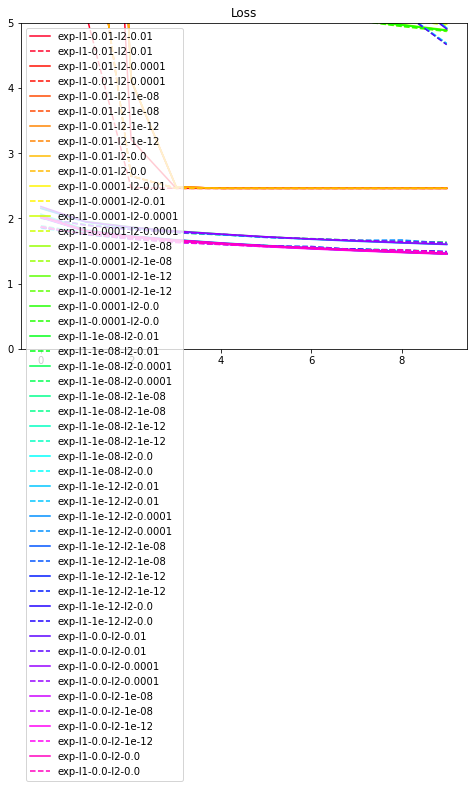

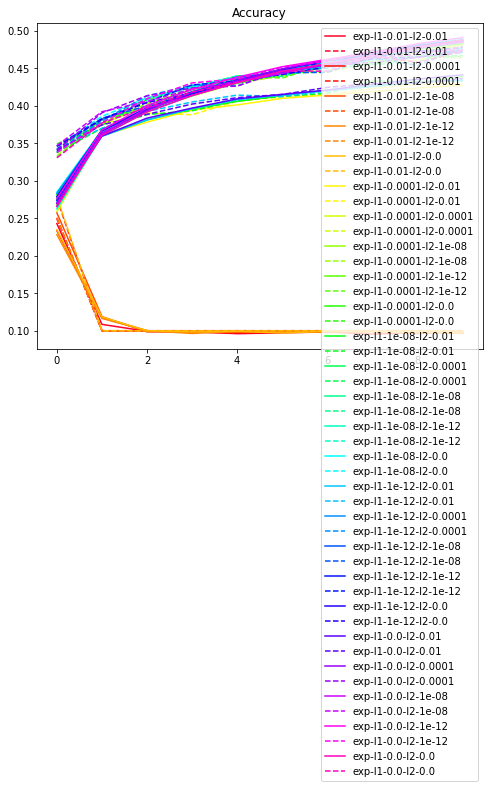

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()